In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

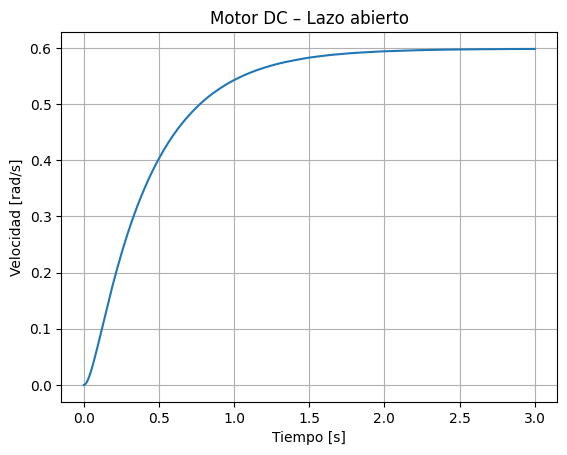

In [13]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

R,L,Ke,Kt,J,b = 2,0.1,0.05,0.05,0.2,0.5
A = np.array([[-R/L, -Ke/L],[Kt/J, -b/J]])
B = np.array([[1/L],
              [0.0]]);
C = np.array([[0,1]])

def motor_dc(t, x, u):
    x = np.asarray(x).reshape(-1, 1)             # (2,1)
    dx = A @ x + B * u                           # (2,1)
    return dx.flatten() 

u=12; #Volts
x0=np.zeros(2) #Initial Conditions
t_eval=np.linspace(0,3,400) #Simulation Time 3s
sol=solve_ivp(motor_dc,(0,3),x0,args=(u,),t_eval=t_eval) #Solve differential equation
y=(C@sol.y).flatten() #Multiply C*x in which X are system states
plt.plot(sol.t,y)
plt.title("Motor DC – Lazo abierto")
plt.xlabel("Tiempo [s]") 
plt.ylabel("Velocidad [rad/s]") 
plt.grid(); 
plt.show()


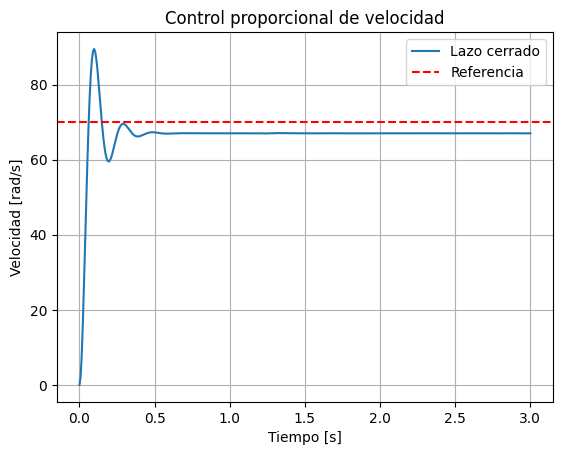

In [14]:

# CLOSED LOOP
Kp=450; 
r=70 #Referencia velocidad rad/s
def closed_loop(t,x):
    y=(C@x).item();
    e=r-y;
    u=Kp*e
    x = np.asarray(x).reshape(-1, 1)             # (2,1)
    dx = A @ x + B * u                           # (2,1)
    return dx.flatten() 

sol2=solve_ivp(closed_loop,(0,3),x0,t_eval=t_eval)
y2=(C@sol2.y).flatten()
plt.plot(sol2.t,y2,label="Lazo cerrado")
plt.axhline(r,color='r',ls='--',label="Referencia")
plt.legend(); plt.title("Control proporcional de velocidad")
plt.xlabel("Tiempo [s]"); plt.ylabel("Velocidad [rad/s]"); plt.grid(); plt.show()

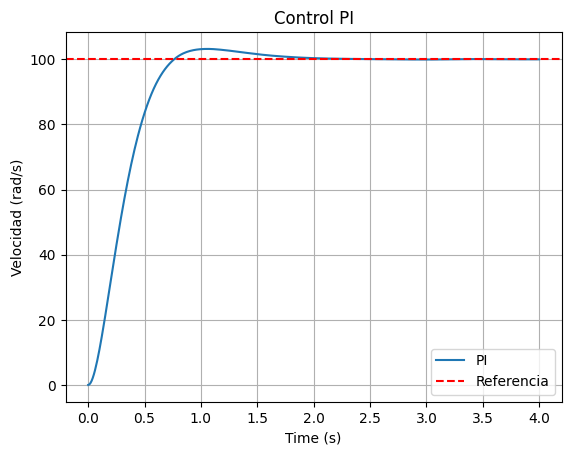

In [38]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#Parametros del motor
R,L, Ke, Kt, J, b = 1,0.5,0.01,0.01,0.01,0.1
A = np.array([[-R/L, -Ke/L],[Kt/J, -b/J]])
B = np.array([1/L,0])
C = np.array([0,1])
#Control Proporcional
Kp = 15
#Control Integral
Ki = 35
#Setpoint
r = 100 #rad/s
def motor_PI(t,x):
    i,w,integral = x
    y = w
    e = r - y
    u = Kp*e + Ki*integral
    di_dt = (-R*i - Ke*w + u)/L
    dw_dt = (Kt*i - b*w)/J
    dint_dt = e
    return [di_dt, dw_dt, dint_dt]
x0 = [0,0,0]
t_eval = np.linspace(0,4,400)
sol = solve_ivp(motor_PI, (0,4),x0, t_eval=t_eval)
y = sol.y[1]
plt.plot(sol.t, y, label = 'PI')
plt.axhline (r, color='r', ls='--',label='Referencia')
plt.legend()
plt.title('Control PI')
plt.xlabel('Time (s)')
plt.ylabel('Velocidad (rad/s)')
plt.grid()
plt.show()

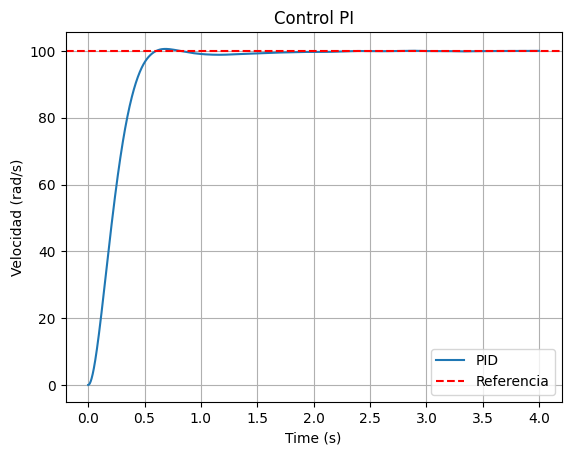

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#Parametros del motor
R,L, Ke, Kt, J, b = 1,0.5,0.01,0.01,0.01,0.1
A = np.array([[-R/L, -Ke/L],[Kt/J, -b/J]])
B = np.array([1/L,0])
C = np.array([0,1])
#Control Proporcional
Kp = 20
#Control Integral
Ki = 45

Kd = 3.5
#Setpoint
r = 100 #rad/s


def motor_PI(t,x):
    i,w,integral,prev_e = x
    y = w
    e = r - y
    de_dt = e - prev_e
    #DE/DT = (error_actual - error_previo)
    #Control PI
    #u = Kp*e + Ki*integral
    #Control PD
    #u = Kp*e + Kd*de_dt
    #Control PID
    u = Kp*e + Ki*integral + Kd*de_dt

    di_dt = (-R*i - Ke*w + u)/L
    dw_dt = (Kt*i - b*w)/J
    dint_dt = e
    return [di_dt, dw_dt, dint_dt, e]


x0 = [0,0,0,0]
t_eval = np.linspace(0,4,1600)
sol = solve_ivp(motor_PI, (0,4),x0, t_eval=t_eval)
y = sol.y[1]
plt.plot(sol.t, y, label = 'PID')
plt.axhline (r, color='r', ls='--',label='Referencia')
plt.legend()
plt.title('Control PID')
plt.xlabel('Time (s)')
plt.ylabel('Velocidad (rad/s)')
plt.grid()
plt.show()

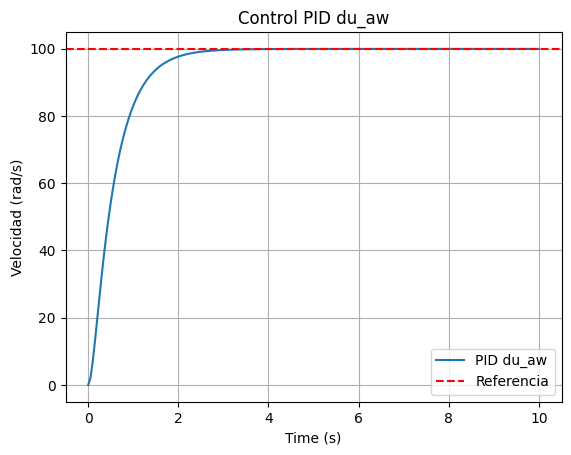

In [56]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#Parametros del motor
R,L, Ke, Kt, J, b = 1,0.5,0.01,0.01,0.01,0.1
A = np.array([[-R/L, -Ke/L],[Kt/J, -b/J]])
B = np.array([1/L,0])
C = np.array([0,1])
#Control Proporcional
Kp = 15
#Control Integral
Ki = 35

Kd = 5
#Setpoint
r = 100 #rad/s


u_min = -1000
u_max = 1000
tau =0.5
def motor_PI(t,x):
    i,w,integral,prev_e = x
    y = w
    e = r - y
    de_dt = e - prev_e
    #DE/DT = (error_actual - error_previo)
    #Control PI
    #u = Kp*e + Ki*integral
    #Control PD
    #u = Kp*e + Kd*de_dt
    u = Kp*e + Ki*integral + Kd*de_dt
    u_sat = np.clip(u,u_min,u_max)
    du_aw = (u - u_sat)/tau
    di_dt = (-R*i - Ke*w + u_sat)/L
    dw_dt = (Kt*i - b*w)/J
    dint_dt = e + du_aw
    return [di_dt, dw_dt, dint_dt, e]


x0 = [0,0,0,0]
t_eval = np.linspace(0,80,1600)
sol = solve_ivp(motor_PI, (0,80),x0, t_eval=t_eval)
y = sol.y[1]
plt.plot(sol.t, y, label = 'PID du_aw')
plt.axhline (r, color='r', ls='--',label='Referencia')
plt.legend()
plt.title('Control PID du_aw')
plt.xlabel('Time (s)')
plt.ylabel('Velocidad (rad/s)')
plt.grid()
plt.show()